In [187]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [188]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.callbacks import EarlyStopping

# **1. XỬ LÝ DATASET**

# **#. LOAD DATASET**

In [189]:
BATCH_SIZE = 50
IMAGE_SIZE = 255
CHANNEL = 3
EPOCHS = 20

In [ ]:
# load dataset và chia batch (images, labels)
ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory='/content/drive/MyDrive/crop-disease-classification/dataset/Potato',
  seed=123,       # kết quả giống nhau mỗi lần xáo trộn
  shuffle = True,
  image_size=(IMAGE_SIZE,IMAGE_SIZE),  # 255x255
  batch_size = BATCH_SIZE,
)

ds

Found 1510 files belonging to 3 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [191]:
total_batch = len(ds)  #tổng số batch: 1510/50
total_batch

31

In [192]:
first_batch = ds.take(1)  #lấy batch đầu tiên
len(ds.take(1))

1

1 epoch = tổng số batch = n/batch_size

In [193]:
for images_tf, labels_tf in ds.take(1):  # take(1) lấy 1 batch đầu tiên
    print("images_tf Shape:", images_tf.shape)  # 4D
    print("labels_tf Shape:", labels_tf.shape)  # 1D
    print("image shape:", images_tf[0].shape)  # 3D
    print("Label numpy:", labels_tf.numpy) # labels_tf.numpy()

images_tf Shape: (50, 255, 255, 3)
labels_tf Shape: (50,)
image shape: (255, 255, 3)
Label numpy: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(50,), dtype=int32, numpy=
array([0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2,
       2, 1, 2, 1, 0, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 0,
       1, 2, 2, 0, 2, 2], dtype=int32)>>


In [194]:
# 3 nhãn
labels = ds.class_names
labels

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

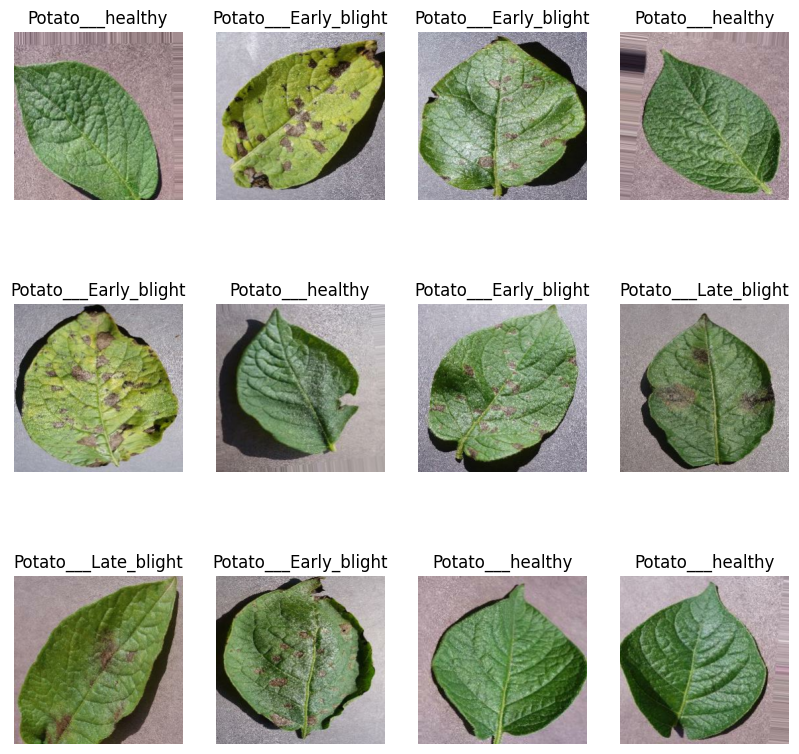

In [195]:
def display_imgs():
  plt.figure(figsize=(10, 10)) #10 inch × 10 inch

  for images_tf, labels_tf in ds.take(1):
      for item in range(12):
          ax = plt.subplot(3, 4, item + 1) # vẽ trục: 3x4, bắt đầu từ ô thứ 1
          plt.imshow(images_tf[item].numpy().astype("uint8"))
          plt.title(labels[labels_tf[item]])
          plt.axis("off")

display_imgs()

# **#. CHIA DỮ LIỆU**

In [196]:
def split_dataset (ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=123)

    train_ds = ds.take(round(total_batch*0.8)) # 80% train
    remain_batch = ds.skip(len(train_ds))  # 20% còn lại. skip() bỏ qua 19 batch đầu tiên
    val_ds = remain_batch.take(round(total_batch * 0.1)) # 10% val
    test_ds = remain_batch.skip(len(val_ds)) # 10% test

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(ds)

# **#. RESIZE + SCALING**

In [197]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),  # chuẩn hóa giá trị pixel ([0, 255]) về [0, 1]
])

# train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
# val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
# test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

# **#. TĂNG CƯỜNG DỮ LIỆU**

In [198]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), #lật
    layers.RandomRotation(0.2), #xoay
])

#. chỉ tăng cường dữ liệu cho tập train
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)  # chỉ khi train
).prefetch(buffer_size=tf.data.AUTOTUNE)

# **#. CACHE, SHUFFLE, PREFETCH**

In [199]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# **2. MODEL**

In [201]:
# kiến trúc model

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNEL) # cấu trúc 1 image
model = models.Sequential([
    layers.Input(shape=input_shape),

    resize_and_rescale,

    layers.Conv2D(32, kernel_size = (3,3), activation='relu'), # 32 kernel
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # fully-connected, 128 notron
    layers.Dense(128, activation='relu'),

    # softmax phân loại nhiều lớp
    layers.Dense(len(labels), activation='softmax'), # 3 notron cho output-layer
])

model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_29 (Sequential)      │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 253, 253, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 757,443 (2.89 MB)

 Trainable params: 757,443 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

In [202]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # CategoricalCrossentropy cho one-hot label, from_logits=False vì đã sd softmax
    metrics=['accuracy']  # tỷ lệ dự đoán đúng so với tổng số dự đoán
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# fit và train
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 330ms/step - accuracy: 0.3821 - loss: 1.0709 - val_accuracy: 0.5333 - val_loss: 0.8574
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.6673 - loss: 0.7120 - val_accuracy: 0.7800 - val_loss: 0.4874
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.7827 - loss: 0.4811 - val_accuracy: 0.8200 - val_loss: 0.4406
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8597 - loss: 0.3606 - val_accuracy: 0.9533 - val_loss: 0.1666
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9392 - loss: 0.1658 - val_accuracy: 0.8933 - val_loss: 0.3265
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9064 - loss: 0.2783 - val_accuracy: 0.9133 - val_loss: 0.1850
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9001 - loss: 0.2486 - val_accuracy: 0.9600 - val_loss: 0.1412
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9590 - loss: 0.1238 - val_accuracy: 0.9667 -

# **3. ĐÁNH GIÁ MODEL**

In [203]:
scores = model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9742 - loss: 0.1085


In [204]:
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 50, 'steps': 25}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [205]:
history.history['loss'][:5]

[1.008918046951294,
 0.6180486679077148,
 0.4530467689037323,
 0.29561522603034973,
 0.15953697264194489]

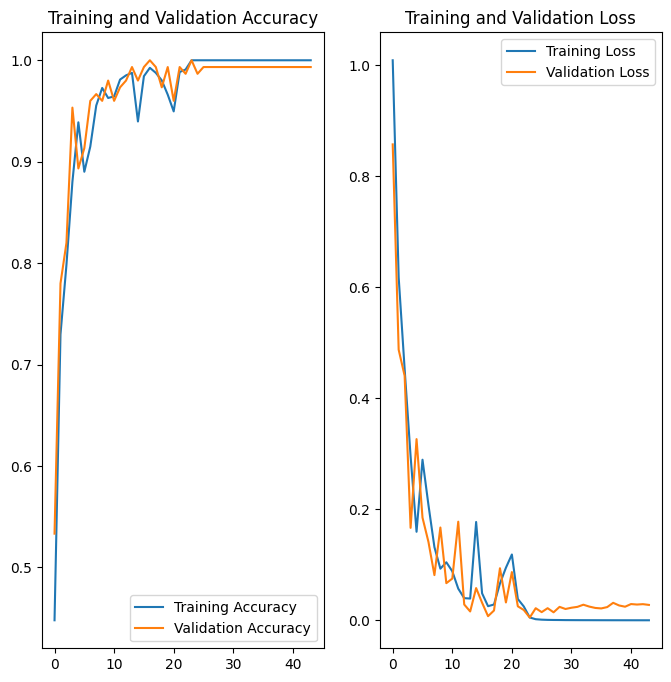

In [206]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [207]:
model.save("/content/drive/MyDrive/crop-disease-classification/model/model.h5")

# **4. DỰ ĐOÁN**

In [208]:
model = tf.keras.models.load_model('/content/drive/MyDrive/crop-disease-classification/model/model.h5')

Shape: (50, 255, 255, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


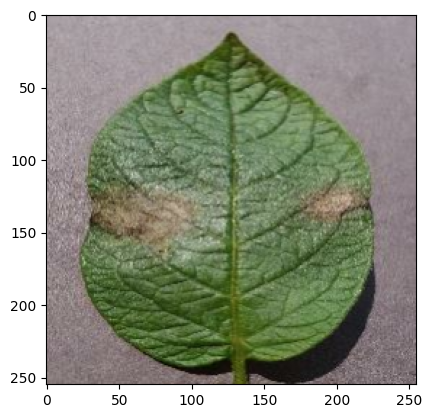

In [209]:
# test
for images_tf, labels_tf in test_ds.take(1):
    print("Shape:", images_tf.shape)

    imgs_predict = resize_and_rescale(images_tf)
    y_predict = model.predict(images_tf)  #2D

    print("actual label:", labels[labels_tf[9]])
    print("predicted label:",labels[np.argmax(y_predict[9])])

    plt.imshow(images_tf[9].numpy().astype("uint8"))

In [218]:
def predict(img_tf):
    F_predict = tf.expand_dims(img_tf, 0)   # chuyển sang 4D (batch_size, h, w, rgb) (cấu trúc 1 batch cho đầu vào model)

    y_predict = model.predict(F_predict) # return 2D

    predicted_label = labels[np.argmax(y_predict[0])]  # lấy chỉ mục của giá trị lớn nhất

    predicted_score = round(np.max(y_predict[0]) * 100, 2) # chuyển về %

    return [predicted_label, predicted_score]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

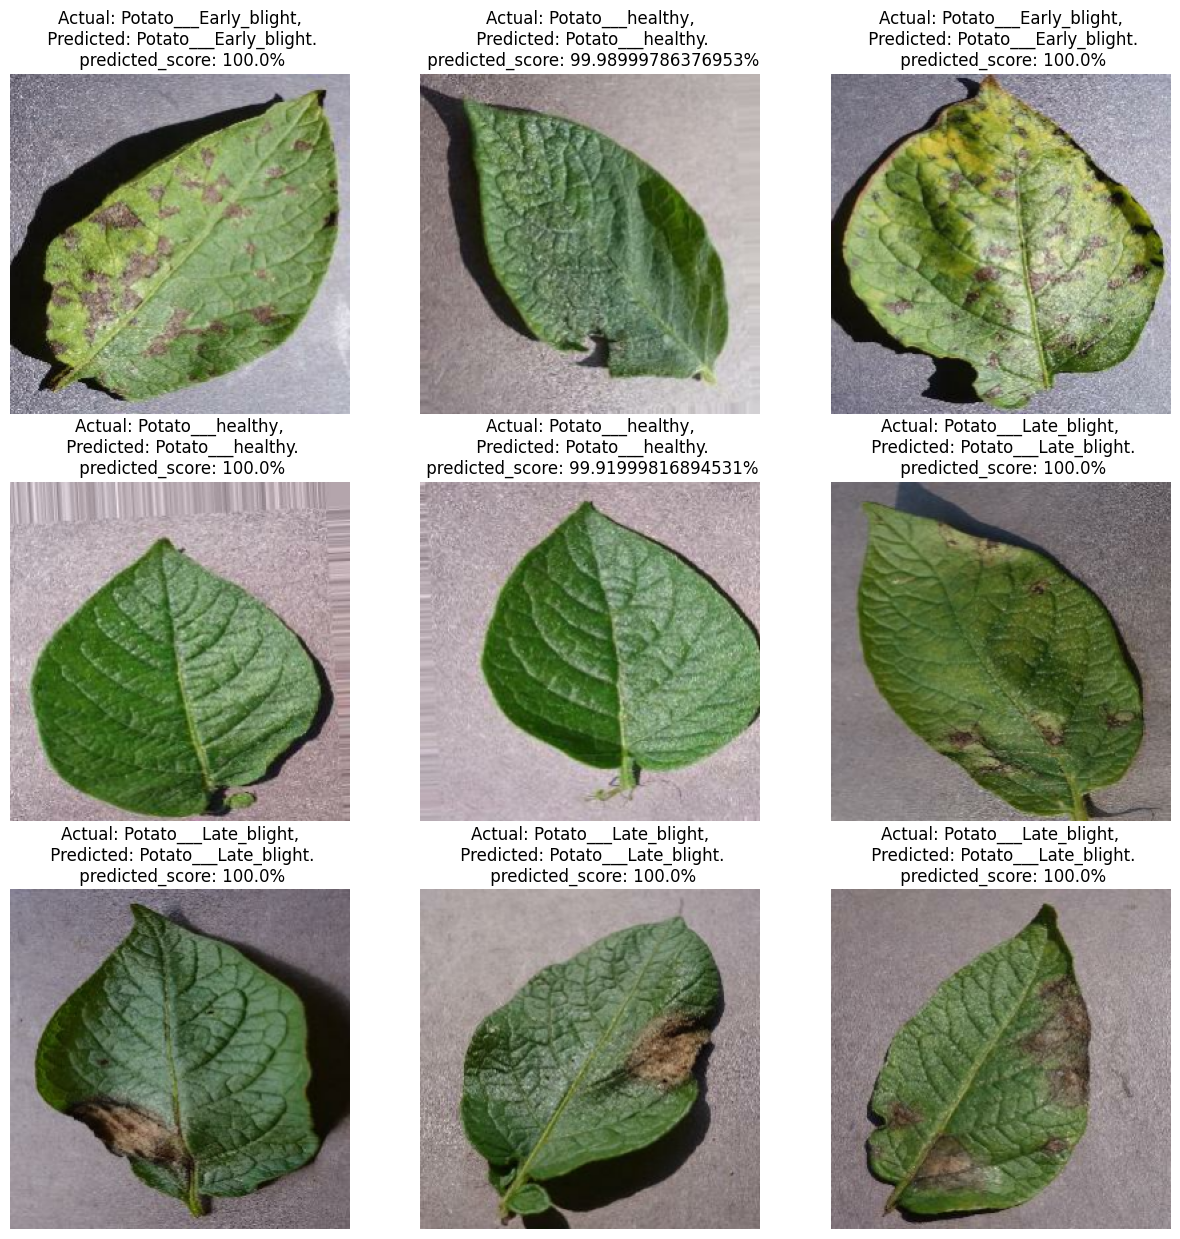

In [222]:
plt.figure(figsize=(15, 15))

for images_tf, labels_tf in test_ds.take(6):
    for i in range(9):
        predicted_label, predicted_score = predict(images_tf[i])

        actual_label = labels[labels_tf[i]]

        ax = plt.subplot(3, 3, i + 1)
        plt.title(f"Actual: {actual_label},\n Predicted: {predicted_label}.\n predicted_score: {predicted_score}%")
        plt.axis("off")
        plt.imshow(images_tf[i].numpy().astype("uint8"))